In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 1000)

In [2]:
filename = 'list_of_dicts.pkl'
with open(filename, 'rb') as file:
    list_of_dicts = pickle.load(file) 

In [3]:

all_relationship_terms = [
    'Spouses',
    'Spouse',
    'Spouse(s)',
    'Partners',
    'Partner',
    'Partner(s)',
]

spouse_terms = [
    'Spouses',
    'Spouse',
    'Spouse(s)',
]

children_terms = [
    'Children',
    'Parent',
    'Parents',
    'Mother',
    'Father',
    'Parent(s)',
    'Children',
]

# Create DataFrame

In [4]:
filtered_data = [
    {
        k: v.replace('\u200b', '') if k in all_relationship_terms else v
        for k, v in entry.items() if k in ['actor'] + all_relationship_terms
    }
    for entry in list_of_dicts
] # add this to replace \xa0

# Define the regex pattern to match each marriage/partnership
pattern = re.compile(r'([a-zA-Z\s]+\(.*?\))')
# pattern = re.compile(r'([a-zA-Z\s]+(?:\(.*?\))?)')

# Initialize an empty list to store the rows
rows = []

# Iterate through each entry in the filtered_data
for entry in filtered_data:
    actor = entry['actor']
    for key in all_relationship_terms:
        if key in entry:
            # Find all matches for the current relationship term (Spouses, Partners, etc.)
            matches = pattern.findall(entry[key])
            for match in matches:
                rows.append({
                    'actor': actor,
                    'variable': key,
                    'value': match.strip()  # Strip any leading/trailing whitespace
                })
    # if not any(x in all_relationship_terms for x in entry.keys()):
    #     rows.append({
    #             'actor': actor,
    #             'variable': 'Never',
    #             'value': 'never'  # Strip any leading/trailing whitespace
    #         })



In [5]:
# Create the DataFrame from the rows
df = pd.DataFrame(rows, columns=['actor', 'variable', 'value'])

## extract names & the details
# Updated regex pattern
pattern = r'([a-zA-Z\s]*?)\s*(\(.*\))'

# Apply the regex to extract the matches into two columns
df[['name', 'details']] = df['value'].str.extract(pattern).apply(lambda x: x.str.strip())

pattern = re.compile(r'([a-zA-Z]+\.? \d{4})\s* *;? *\s*([a-zA-Z]+\.? \d{4})?') #re.compile(r'([a-zA-Z]{1,4}\.\s*\d{4})(?:;\s*([a-zA-Z]{1,4}\.\s*\d{4}))?')

pattern = re.compile(r'\(\s*([a-zA-Z]+\.?\s*\d{4})\s*(?:;?\s*([a-zA-Z]+\.?\s*\d{4}))?\s*\)')
## Apply the regex to extract the matches into two columns
df[['first_event', 'second_event']] = df['details'].str.extract(pattern)

## Broken rows
# df[(df['variable'].isin(spouse_terms)) & (df['first_event'].isnull())][['actor', 'value', 'details', 'first_event']] # 24 missing, to address here
# df[(df['variable'].isin(spouse_terms)) & (df['second_event'].isnull()) & df['details'].str.contains(r',|[a-zA-Z]{4,}|-', na=False) ][['actor', 'details', 'value', 'second_event']].details.unique() # 17 incorrectly considered survived here

# df[(df['variable'].isin(spouse_terms)) & (df['second_event'].isnull()) & ~df['details'].str.contains(r'\( ?m. ?\d{4} ?\)', na=False, regex = True) ][['actor', 'details', 'value', 'second_event']] # kind of same as above
# df[df['variable'].isin(spouse_terms) & df['details'].str.contains(',')] # should be take ncare of by the above
# df[(df['variable'].isin(spouse_terms)) & (df['details'].isnull())] # good
# df[(df['variable'].isin(spouse_terms)) & (df['first_event'].notnull())]['first_event'].unique() # two or 3 things broken
# df[df['variable'].isin(spouse_terms)].groupby('first_abbrev').count() # very small amount of brokens
# df[ ( df['variable'].isin(spouse_terms) ) & ( df['second_abbrev'].isnull())  ].second_event.unique() # just dieds, so this is kind of ok

## get out the m. and the year
df['first_abbrev'] = df['first_event'].str.extract(r'(\w+)\.? ')
df['second_abbrev'] = df['second_event'].str.extract(r'(\w+)\.? ')
## if your marriage makes it, then give the np.nan a "surv" for survived
df.loc[ (df.variable.isin(spouse_terms)) & ( df['second_abbrev'].isnull() ), 'second_abbrev'] = 'surv'

## lazy man's cop for top two breakages:
df = df[ ~( (df['variable'].isin(spouse_terms)) & (df['first_event'].isnull()) )]#[['actor', 'value', 'details', 'first_event']] # 24 missing, to address here
df = df[ ~( (df['variable'].isin(spouse_terms)) & (df['second_event'].isnull()) & df['details'].str.contains(r',|[a-zA-Z]{4,}|-', na=False) ) ]#.details.unique() # 17 incorrectly considered survived here


df.actor.nunique() # 861 people


861

In [6]:
tmp_df = pd.DataFrame(list_of_dicts)
for entry in list_of_dicts:
    if entry['actor'] == 'Clint Eastwood': # weirdly unscrapable, not clear why
        print(entry)

tmp_df[~tmp_df['actor'].isin(df['actor'].unique())][['actor'] + all_relationship_terms].isnull().sum()

missings = tmp_df[~tmp_df['actor'].isin(df['actor'].unique())]['actor'].tolist() # a lot of these couldn't scrape, wasn't super clear why

{'actor': 'Clint Eastwood', 'url': 'https://en.wikipedia.org/wiki/Clint_Eastwood'}


# Analysis

In [7]:
working = df[df['variable'].isin(spouse_terms)]

## make bind annulments, separations, and divorces together. died and survived are the same
working = working.replace('ann', 'ended').replace('annul', 'ended').replace('div', 'ended').replace('sep', 'ended')\
                 .replace('died', 'survived').replace('surv', 'survived').replace('m', 'married')

## drop the broken ones
working = working[~working['first_abbrev'].isin(['ended','c'])]
working = working[(df['variable'].isin(spouse_terms)) & (df['first_event'].notnull())]

##### Counts of marriages, actors
## Number of actors who were married
working.actor.nunique() # 804

## Number of marriages. 
len(working)

## count of marriages per actor
actor_marriage_count_table = working.groupby('actor')['first_abbrev'].count().reset_index().rename(columns = {'first_abbrev':'count'})
print(f'number of 0s in actor_marriage_count_table {len(actor_marriage_count_table[actor_marriage_count_table['count'] == 0])}')
actor_marriage_count_table = actor_marriage_count_table[actor_marriage_count_table['count'] != 0] # remove the 0s, data errors to return to

## Num of actors who were married 1,2,3, etc. times
marriage_distro_table = actor_marriage_count_table.groupby('count')['actor'].count().reset_index()
cutoff_number = 3
## create 3+ group
marriage_distro_table['group'] = marriage_distro_table['count'].apply(lambda x: f'{cutoff_number}+' if x >= cutoff_number else str(x))
# Group by the new 'group' column and sum the 'actor' counts
marriage_distro_trunc = marriage_distro_table.groupby('group', as_index=False)['actor'].sum()
marriage_distro_trunc

number of 0s in actor_marriage_count_table 0


/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_18668/3338218688.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  working = working[(df['variable'].isin(spouse_terms)) & (df['first_event'].notnull())]


,group,actor
0,1,426
1,2,212
2,3+,159


In [30]:
# working = df[df['variable'].isin(spouse_terms)]
working.actor.nunique()
len(working)
working[~working['actor'].isin(actor_marriage_count_table['actor'])]

working.actor.nunique()
len(working)

1424

In [9]:
# Barchart function with optional legend location
def basic_barchart(x, y, df, xlabel, ylabel, title, hue=None, legend_loc='best'):
    if hue:
        ax = sns.barplot(x=x, y=y, data=df, hue=hue, edgecolor='black')
    else:
        ax = sns.barplot(x=x, y=y, data=df, edgecolor='black')

    # Add text labels
    for container in ax.containers:
        # Determine whether the data is in percentage format (decimals) or whole numbers
        labels = []
        for v in container.datavalues:
            if isinstance(v, float) and v < 1:
                labels.append(f'{v:.0%}')  # Convert to percentage format
            else:
                labels.append(f'{int(v)}')  # Keep as a whole number

        ax.bar_label(container, labels=labels, label_type='edge', padding=3)

    # Set the legend location
    if hue:
        plt.legend(loc=legend_loc)

    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    plt.show()


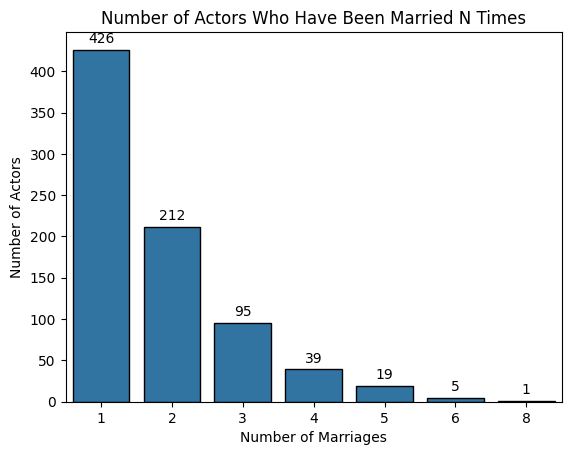

In [10]:
x = 'count'
y = 'actor'
df = marriage_distro_table
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Number of Actors Who Have Been Married N Times'
basic_barchart(x, y, df, xlabel, ylabel, title)

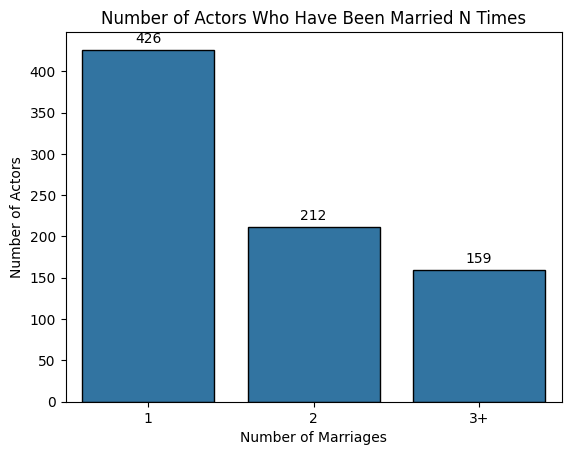

In [24]:
x = 'group'
y = 'actor'
df = marriage_distro_trunc
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Number of Actors Who Have Been Married N Times'
basic_barchart(x, y, df, xlabel, ylabel, title)

<Figure size 640x480 with 0 Axes>

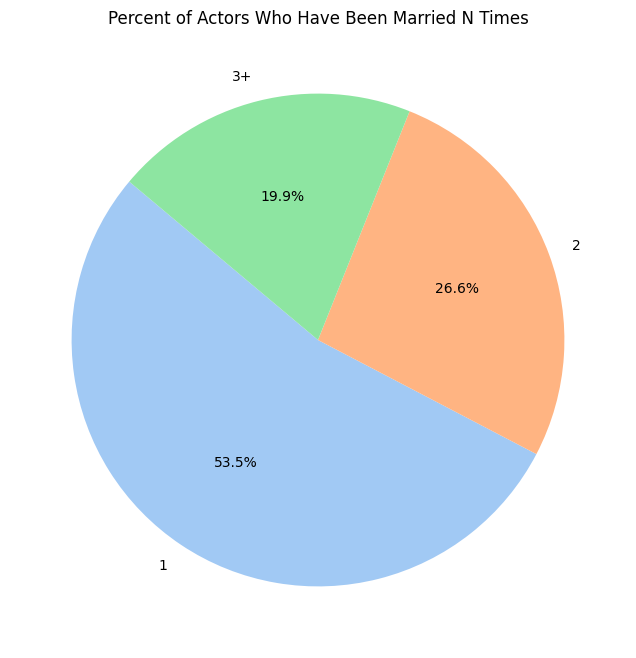

In [32]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.pie(marriage_distro_trunc['actor'], labels=marriage_distro_trunc['group'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

# Add a title
plt.title('Percent of Actors Who Have Been Married N Times')

# Display the pie chart
plt.show()

<Figure size 640x480 with 0 Axes>

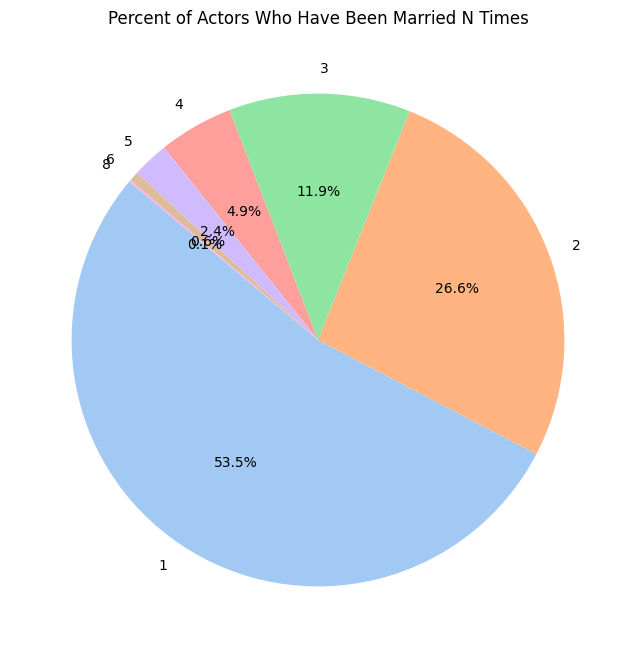

In [23]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.pie(marriage_distro_table['actor'], labels=marriage_distro_table['count'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

# Add a title
plt.title('Percent of Actors Who Have Been Married N Times')

# Display the pie chart
plt.show()

In [13]:
##### Rates of Divorces

assert working['actor'].isnull().sum() == 0

## divorce rate across all
divorce_counts = working.groupby(['first_abbrev', 'second_abbrev'])['actor'].count()
divorce_counts / divorce_counts.sum()# lost 40ish marriages, can look into those


## divorce rates for 1st, 2nd, 3rd etc. marriages

"""
what we can do is based on what number marriage it is, label it in the main table. We could do this with a window function, if you show up 3 times in the main table you had 3 marriages, 2 of which died.
Then groupby the 1st, 2nd, 3rd and the surv/ended counts
""" 
working['marriage_number'] = working.groupby(['actor']).cumcount() + 1
working.loc[working['marriage_number'] >= cutoff_number, 'marriage_number_trunc'] = f'{cutoff_number}+'
working.loc[working['marriage_number'] < cutoff_number, 'marriage_number_trunc'] = working.loc[working['marriage_number'] < cutoff_number, 'marriage_number']
# working['marriage_number'] = 'marriage no. ' + working['marriage_number'].apply(str)

working.groupby(['marriage_number', 'second_abbrev'])['actor'].count() / working.groupby('marriage_number')['actor'].count()#.sum()
working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count() / working.groupby('marriage_number_trunc')['actor'].count()#.sum()


marriage_number_trunc  second_abbrev
1                      ended            0.614806
                       survived         0.385194
2                      ended            0.566038
                       survived         0.433962
3+                     ended            0.554688
                       survived         0.445312
Name: actor, dtype: float64

In [33]:
divorce_counts
# len(working)
# working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
# working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count()

first_abbrev  second_abbrev
married       ended            842
              survived         582
Name: actor, dtype: int64

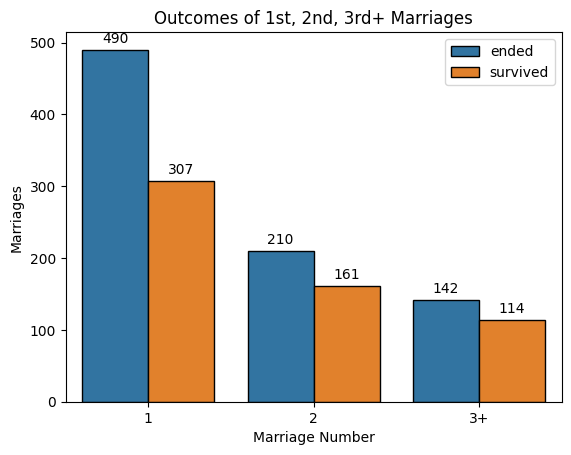

In [15]:
x = 'marriage_number_trunc'
y = 'actor'
hue = 'second_abbrev'
df = working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
xlabel = 'Marriage Number'
ylabel = 'Marriages'
title = 'Outcomes of 1st, 2nd, 3rd+ Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

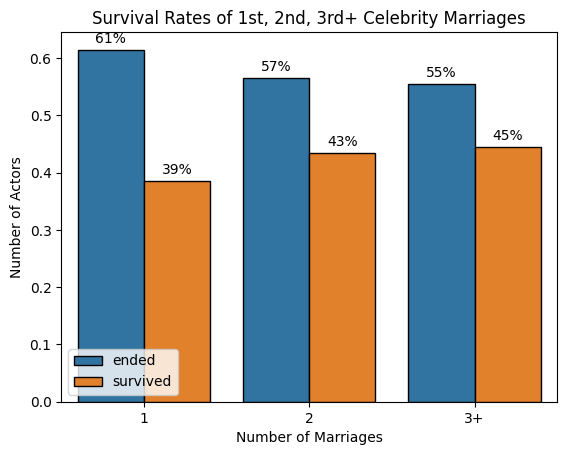

In [34]:
working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
# working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count()

x = 'marriage_number_trunc'
y = 'actor'
hue = 'second_abbrev'
df = (working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count() / working.groupby(['marriage_number_trunc'])['actor'].count()).reset_index()
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Survival Rates of 1st, 2nd, 3rd+ Celebrity Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue, legend_loc='lower left')

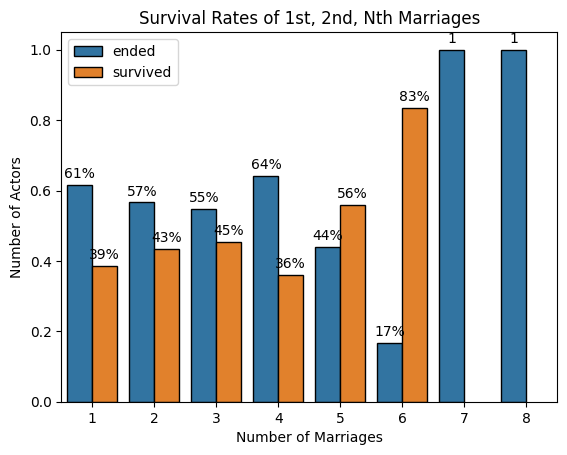

In [17]:
x = 'marriage_number'
y = 'actor'
hue = 'second_abbrev'
df = (working.groupby(['marriage_number', 'second_abbrev'])['actor'].count() / working.groupby(['marriage_number'])['actor'].count()).reset_index()
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Survival Rates of 1st, 2nd, Nth Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

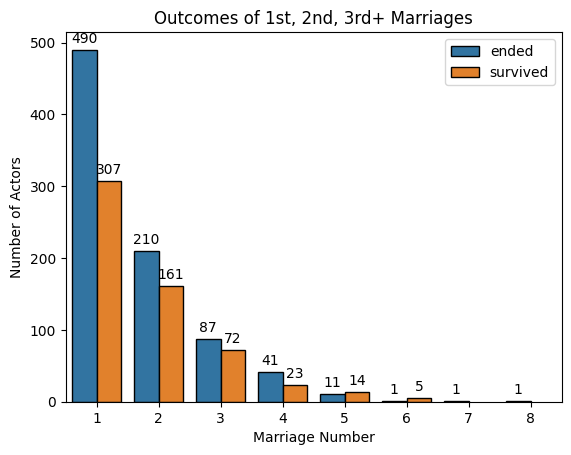

In [18]:
x = 'marriage_number'
y = 'actor'
hue = 'second_abbrev'
df = working.groupby(['marriage_number', 'second_abbrev'])['actor'].count().reset_index()
xlabel = 'Marriage Number'
ylabel = 'Number of Actors'
title = 'Outcomes of 1st, 2nd, 3rd+ Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

# Additional QA

In [19]:
working[ ( working['second_event'].isnull() ) & ( working['second_abbrev'].isnull() ) ] # this check, need to make sure that there's no second events we're missing
working[working['first_abbrev'] == 'c']
working[working['first_abbrev'] == 'ended']
df[df['actor'] == 'Jean Dujardin']
actor_marriage_count_table[actor_marriage_count_table['count'] == 0]

,actor,count


In [20]:
working[working['actor'] == 'Judy Garland']

,actor,variable,value,name,details,first_event,second_event,first_abbrev,second_abbrev,marriage_number,marriage_number_trunc
82,Judy Garland,Spouses,David Rose ( m. 1941; div. 1944),David Rose,( m. 1941; div. 1944),m. 1941,div. 1944,married,ended,1,1
83,Judy Garland,Spouses,Vincente Minnelli ( m. 1945; div. 1951),Vincente Minnelli,( m. 1945; div. 1951),m. 1945,div. 1951,married,ended,2,2
84,Judy Garland,Spouses,Sidney Luft ( m. 1952; div. 1965),Sidney Luft,( m. 1952; div. 1965),m. 1952,div. 1965,married,ended,3,3+
85,Judy Garland,Spouses,Mark Herron ( m. 1965; div. 1969),Mark Herron,( m. 1965; div. 1969),m. 1965,div. 1969,married,ended,4,3+
86,Judy Garland,Spouses,Mickey Deans ( m. 1969),Mickey Deans,( m. 1969),m. 1969,NaN,married,survived,5,3+
